In [1]:
import sys
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
raw_data_folder = os.path.abspath('/home/siedan/programming/masterarbeit/code/analysis/raw_data')


columns = ['matrikel_num', 'Studienjahr', 'geschlecht', 'avgECTS_sem_before', 'ects_year_before', 'year',
           'first_exam_negative', 'AHS_dummy', 'BHS_dummy', 'ausland_vorbildung_dummy',
           'sonstige_vorbildung_dummy', 'delayed_dummy', 'num_parallel_studies', 'jus_dummy',
           'bwl_dummy', 'years_since_matura', 'styria_dummy', 'not_styria_dummy', 'germany_dummy',
           'other_foreign_dummy', 'years_since_18', 'planned_duration','full_duration_sem',
           'full_duration_sem_before', 'firstGen', 'cum_ects_pos_before',
           'status_key', 'ECTS_year', 'SWS_year', 'active_dummy', 'subject']


def load_df(name):
    return pd.read_csv(os.path.join(raw_data_folder, name))

df = load_df('bwl_pad_jus.csv').reset_index(drop = True)


/home/siedan/.cache/pypoetry/virtualenvs/analysis--7SA5cpG-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (25,59) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


## Important DataFrame Adjusments:

In [3]:
# Calculating "full_duration_sem_before" as a new column:
def full_duration_sem_before(df):
    for i in range(len(df)):
        a = math.floor(df.loc[i, "full_duration_sem"])
        if a <= 1:
            df.loc[i, "full_duration_sem_before"] = 0
        else:
            if df.loc[i, "last_semester_name"][2] == 'W':
                df.loc[i, "full_duration_sem_before"] = a - 1
            else:
                df.loc[i, "full_duration_sem_before"] = a - 2
    return df



# Calculating "geschlecht" categorial:
def geschlecht(df):
    for i in range(len(df)):
        a = df.loc[i, "geschlecht"]
        if a == "W":
            df.loc[i, "geschlecht"] = 0
        else:
            df.loc[i,"geschlecht"] = 1
    return df

# Calculating 'cum_ects_pos_before':
def cum_ects_pos_before(df):
    df['cum_ects_pos_before'] = df['avgECTS_sem_before']*df['full_duration_sem_before']
    return df

        
# Calculating "avgECTS_sem_before" as a new column:
def avgECTS_sem_before(df):
    for i in range(len(df)):
        cum_ects_before_pseudo = df.loc[i, 'cumulated_ects_pos'] - df.loc[i, 'ECTS_year']
        if not df.loc[i, 'full_duration_sem_before'] == 0:
            df.loc[i, 'avgECTS_sem_before'] = float(cum_ects_before_pseudo) / df.loc[i, 'full_duration_sem_before']
        else:
            df.loc[i, 'avgECTS_sem_before'] = 0
    return df 


# Calculating "Studienjahr" as a new column:
def Studienjahr(df):
    for i in range(len(df)):
        df.loc[i, "Studienjahr"] = int((df.loc[i, "full_duration_sem_before"]//2) + (df.loc[i, "full_duration_sem_before"]%2) + 1)
    return df


# Deleting row with negative "years since matura":
def Matura(df):
    df.drop(df[df['years_since_matura'] < 0].index, inplace = True)
    return df



# Calculating "ECTS_year_before": (Abschluss bringt nichts; SWS ist egal.)

def year(df):
    for i in df.index:
        num = df.loc[i, 'year'][:2]
        df.loc[i, 'year'] = int(num)
    return df

def ects_year_before(df):  
    list_studienjahre = list(df['year'].unique())
    list_studienjahre.sort()
    for i in list_studienjahre[1:]:
        df_year = df.query('year == @i')
        df_year0 = df.query('year == (@i-1)')
        
        for num in df_year.index:
            if df_year.loc[num, 'Studienjahr'] > 1:
                matr = df_year.loc[num, 'matrikel_num']
                if (num-1) in df_year0.index and df_year0.loc[(num-1), 'matrikel_num'] == matr:
                    df.loc[num, 'ects_year_before'] = df.loc[(num-1), 'ECTS_year']
            
    return df


# Calculating one-hot-encoding for subject:
def subject(df):
    for i in range((len(df))):
        if df.loc[i, 'subject'] == 'Rechtswissenschaften':
            df.loc[i, 'jus_dummy'] = 1
            df.loc[i, 'bwl_dummy'] = 0
        elif df.loc[i, 'subject'] == 'Betriebswirtschaft':
            df.loc[i, 'jus_dummy'] = 0
            df.loc[i, 'bwl_dummy'] = 1
        else:
            df.loc[i, 'jus_dummy'] = 0
            df.loc[i, 'bwl_dummy'] = 0
    return df




In [4]:
# Functions for saving manipulated DataFrame:

def saving(df, name):
    df.to_csv(os.path.join(raw_data_folder, name))


def data_manipulation_pipeline(df, columns, name, save_or_return): # does manipulations to df and is able to save.
    subject(df)
    geschlecht(df)
    full_duration_sem_before(df)
    avgECTS_sem_before(df)
    cum_ects_pos_before(df)
    Studienjahr(df)
    Matura(df)
    year(df)
    ects_year_before(df)
    
    
    df = df[columns] # hier ordne ich die spalten und verwerfe diejenigen, die ich nicht brauche.
    if save_or_return:
        saving(df, name) # adapted_data muesste jetzt eine viel kleinere Datei sein.
    else:
        return df

    
data_manipulation_pipeline(df, columns, 'adapted_data.csv', True)



In [5]:
df_working = load_df('adapted_data.csv')[columns] # laden des DataFrames, welches ich tatsaechlich verwende.
df_working

,matrikel_num,Studienjahr,geschlecht,avgECTS_sem_before,ects_year_before,year,first_exam_negative,AHS_dummy,BHS_dummy,ausland_vorbildung_dummy,...,planned_duration,full_duration_sem,full_duration_sem_before,firstGen,cum_ects_pos_before,status_key,ECTS_year,SWS_year,active_dummy,subject
0,3564,13.0,0,0.041667,NaN,16,0.0,1,0,0,...,8,26.000000,24.0,NaN,1.0,I,0.0,0.0,0,Rechtswissenschaften
1,3564,14.0,0,0.038462,0.0,17,0.0,1,0,0,...,8,28.000000,26.0,NaN,1.0,I,0.0,0.0,0,Rechtswissenschaften
2,3564,15.0,0,0.035714,0.0,18,0.0,1,0,0,...,8,30.000000,28.0,NaN,1.0,Z,0.0,0.0,0,Rechtswissenschaften
3,7834,11.0,1,5.475000,NaN,15,1.0,1,0,0,...,8,21.542466,20.0,NaN,109.5,X,0.0,0.0,1,Rechtswissenschaften
4,10035,10.0,0,1.441176,NaN,17,0.0,0,0,1,...,8,19.000000,17.0,NaN,24.5,I,0.0,0.0,0,Rechtswissenschaften
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39937,51866425,1.0,0,0.000000,NaN,18,0.0,1,0,0,...,6,1.000000,0.0,1.0,0.0,I,8.0,5.0,0,Padagogik
39938,51866425,2.0,0,8.000000,8.0,19,0.0,1,0,0,...,6,3.000000,1.0,1.0,8.0,I,7.0,4.0,0,Padagogik
39939,51871418,1.0,0,0.000000,NaN,19,1.0,0,1,0,...,6,2.000000,0.0,1.0,0.0,I,29.0,19.0,1,Betriebswirtschaft
39940,51907081,1.0,1,0.000000,NaN,19,1.0,1,0,0,...,6,2.000000,0.0,NaN,0.0,I,16.0,9.0,1,Betriebswirtschaft


In [21]:
for i in [1, 2, 3, 4, 5, 6]:
    print(len(df_working.query('Studienjahr == @i')))
    
print(len(df_working.query('Studienjahr >= 7')))

9091
7066
5609
4535
3076
2250
8315


## Graphics:

In [7]:
# Calculation of the distribution of active people:



df_bwl = df_working.copy(deep = True).query('subject == "Betriebswirtschaft"')
df_jus = df_working.copy(deep = True).query('subject == "Rechtswissenschaften"')
df_pad = df_working.copy(deep = True).query('subject == "Padagogik"')






def distribution_active(df):  # berechnet den Anteil der aktiven Studierenden an allen Studierenden im Datensatz.
    active_num = 0
    for student in df['active_dummy']:
        if student == 1:
            active_num += 1
            
    return active_num/len(df)


## Plotting:


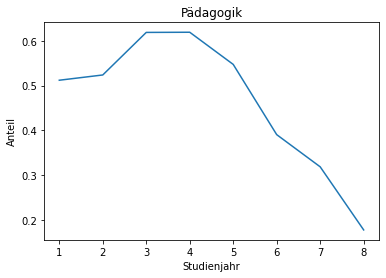

In [33]:
t = [1,2,3,4,5,6,7,8]
x = []

for studienjahr in t:
#     x.append(distribution_active(df_working.query('Studienjahr == @studienjahr')))
#     x.append(distribution_active(df_bwl.query('Studienjahr == @studienjahr')))
#     x.append(distribution_active(df_jus.query('Studienjahr == @studienjahr')))
    x.append(distribution_active(df_pad.query('Studienjahr == @studienjahr')))
    

plt.plot(t,x)

# plt.title('Gesamt')
# plt.title('Betriebswirtschaft')
# plt.title('Rechtswissenschaften')
plt.title('Pädagogik')


plt.ylabel('Anteil')
plt.xlabel('Studienjahr')

# plt.savefig('ges1.pdf')
# plt.savefig('bwl1.pdf')
# plt.savefig('jus1.pdf')
plt.savefig('pad1.pdf')

plt.show()

In [9]:
# %matplotlib inline

# df2 = df1.copy(deep = True)

# from pandas.plotting import scatter_matrix
# attributes = ["ECTS_year", "avgECTS_sem_before", 'Studienjahr', "ects_year_before", "firstGen", "num_parallel_studies"]
# scatter_matrix(df2[attributes], figsize=(14,10))

# df3 = df1.query('Studienjahr < 9 and subject == "Rechtswissenschaften"').copy(deep = True)

# x = np.array(df3['Studienjahr'])
# y = np.array(df3['ECTS_year'])

# plt.hist2d(x,y, bins = 8, cmap = 'plasma')

# cb = plt.colorbar()
# cb.set_label('Number of entries')

# plt.show()

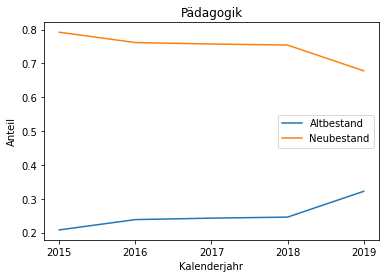

In [34]:
t = [2015,2016,2017,2018,2019]
x = []
y = []

for year in [15,16,17,18,19]:
#     df_trial = df_working.query('year == @year and active_dummy == 1')
#     df_trial = df_bwl.query('year == @year and active_dummy == 1')
#     df_trial = df_jus.query('year == @year and active_dummy == 1')
    df_trial = df_pad.query('year == @year and active_dummy == 1')
    
    x.append(len(df_trial.query('Studienjahr >= 4'))/len(df_trial))
    y.append(len(df_trial.query('Studienjahr < 4'))/len(df_trial))
    

plt.plot(t,x, label='Altbestand')
plt.plot(t,y, label='Neubestand')

# plt.title('Gesamt')
# plt.title('Betriebswirtschaft')
# plt.title('Rechtswissenschaften')
plt.title('Pädagogik')

plt.ylabel('Anteil')
plt.xlabel('Kalenderjahr')
plt.xticks(t)
plt.legend()

# plt.savefig('ges2.pdf')
# plt.savefig('bwl2.pdf')
# plt.savefig('jus2.pdf')
plt.savefig('pad2.pdf')

plt.show()


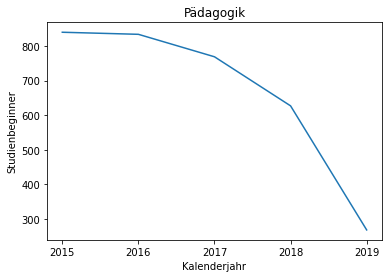

In [35]:
t = [2015,2016,2017,2018,2019]
x = []

for year in [15,16,17,18,19]:
#     x.append(len(df_working.query('year == @year and Studienjahr == 1')))
#     x.append(len(df_bwl.query('year == @year and Studienjahr == 1')))
#     x.append(len(df_jus.query('year == @year and Studienjahr == 1')))
    x.append(len(df_pad.query('year == @year and Studienjahr == 1')))
    
plt.plot(t,x)

# plt.title('Gesamt')
# plt.title('Betriebswirtschaft')
# plt.title('Rechtswissenschaften')
plt.title('Pädagogik')

plt.ylabel('Studienbeginner')
plt.xlabel('Kalenderjahr')
plt.xticks(t)
# plt.savefig('ges3.pdf')
# plt.savefig('bwl3.pdf')
# plt.savefig('jus3.pdf')
plt.savefig('pad3.pdf')

plt.show()


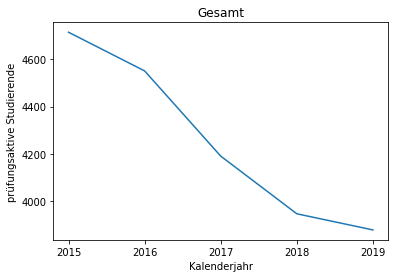

In [38]:
t = [2015,2016,2017,2018,2019]
x = []

for year in [15,16,17,18,19]:
    x.append(len(df_working.query('year == @year and active_dummy == 1')))
#     x.append(len(df_bwl.query('year == @year and active_dummy == 1')))
#     x.append(len(df_jus.query('year == @year and active_dummy == 1')))
#     x.append(len(df_pad.query('year == @year and active_dummy == 1')))
    
plt.plot(t,x)
    
plt.title('Gesamt')
# plt.title('Betriebswirtschaft')
# plt.title('Rechtswissenschaften')
# plt.title('Pädagogik')

plt.ylabel('prüfungsaktive Studierende')
plt.xlabel('Kalenderjahr')
plt.xticks(t)
plt.savefig('ges4.pdf')
# plt.savefig('bwl4.pdf')
# plt.savefig('jus4.pdf')
# plt.savefig('pad4.pdf')

plt.show()

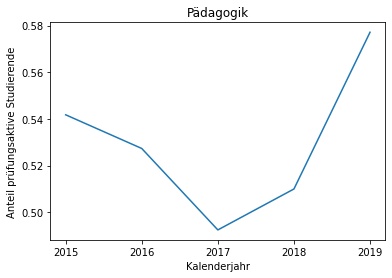

In [37]:
t = [2015,2016,2017,2018,2019]
x = []

for year in [15,16,17,18,19]:
#     x.append(distribution_active(df_working.query('year == @year')))
#     x.append(distribution_active(df_bwl.query('year == @year')))
#     x.append(distribution_active(df_jus.query('year == @year')))
    x.append(distribution_active(df_pad.query('year == @year')))
    
plt.plot(t,x)
    
# plt.title('Gesamt')
# plt.title('Betriebswirtschaft')
# plt.title('Rechtswissenschaften')
plt.title('Pädagogik')

plt.ylabel('Anteil prüfungsaktive Studierende')
plt.xlabel('Kalenderjahr')
plt.xticks(t)
# plt.savefig('ges5.pdf')
# plt.savefig('bwl5.pdf')
# plt.savefig('jus5.pdf')
plt.savefig('pad5.pdf')

plt.show()

In [14]:
# df1.loc[20650] # Joni

In [15]:
# df5 = df1.query('matrikel_num == 1411689', inplace = False) # Joni
# df5

# Splitting the Dataframe in different parts:


In [8]:
# def split(df, column):
#     grouped = df.groupby([column])
#     return_list = []
#     for i in df[column].unique():
#         return_list.append(grouped.get_group(i).reset_index(drop = True))
#     return return_list


# list_subject = split(df_working, 'subject')
# list_year = split(df_working, 'year')
# list_studienjahr = split(df_working, 'Studienjahr')



<AxesSubplot:ylabel='Frequency'>

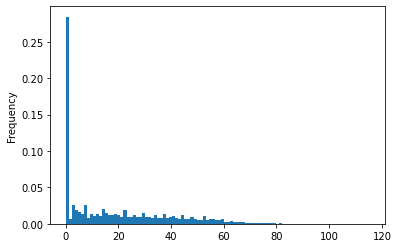

In [9]:
# df_working['ECTS_year'].plot.hist(bins = 100, density = True)

In [151]:
# for df in list_year:
#     print(df['year'][0])
#     plt.hist(df['ECTS_year'], bins = 30)
#     plt.show()

In [152]:
# for df in list_studienjahr:
#     print(df['Studienjahr'][0])
#     plt.hist(df['ECTS_year'], bins = 30)
#     plt.show()

In [153]:
# for df in list_subject:
#     print(df['subject'][0])
#     x = df['ECTS_year']
#     plt.hist(x, bins = 30, density = True)
#     plt.show()

## Building Dataframe for test of BIG MODELS: (Contaminated)

- Here I have a dataset, which contains pupils, which are studying for at least 4 years in a row.

In [155]:
# df1 = load_df('adapted_data.csv')[columns] # erneutes laden des Datensatzes

# df1 = pd.concat([df_a, df_b]) 

# list_subjects = split(df1, 'subject') # um keine Faecherueberscheidung bei gewissen Studierenden zu haben.

# result_list = []
# for df in list_subjects:
#     df = df.drop_duplicates(['matrikel_num', 'Studienjahr'])
#     clear_df = pd.concat(g for _, g in df.groupby(['matrikel_num', 'planned_duration']) if len(g) > 2)
#     result_list.append(clear_df)
    
# df_pretty = pd.concat(df for df in result_list)

# groups = df_pretty.groupby('matrikel_num')
# list_of_students = [] # list von df's, wobei jedes df einen Studenten oder eine Studentin ueber mehrere Jahre hinweg beschreibt.

# for i in df_pretty['matrikel_num'].drop_duplicates():
#     list_of_students.append(groups.get_group(i))
    
# len(list_of_students)


# saving(df_pretty, 'df_pretty.csv')